## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# load in packages
from itertools import combinations
from test_results import  test_results, score

import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline



## Data Understanding

### Training data

In [2]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [3]:
#find out the shape of the data
train_data.shape

(84534, 10)

In [4]:
#summary stats  on the data
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [5]:
#How many promotions were Yes and How many were no
train_data['Promotion'].value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [6]:
# proportion of promotions given vs promotions not given in the data
train_data['Promotion'].value_counts()/train_data.shape[0]

Yes    0.501147
No     0.498853
Name: Promotion, dtype: float64

In [7]:
# What are the data types in our data
train_data.dtypes

ID             int64
Promotion     object
purchase       int64
V1             int64
V2           float64
V3           float64
V4             int64
V5             int64
V6             int64
V7             int64
dtype: object

In [8]:
# how many purchased vs how many did not purchase
train_data['purchase'].value_counts()

0    83494
1     1040
Name: purchase, dtype: int64

In [9]:
# proportions of those who purchased vs those who ddnt
train_data['purchase'].value_counts()/train_data.shape[0]

0    0.987697
1    0.012303
Name: purchase, dtype: float64

In [10]:
train_data[['Promotion','purchase']].groupby(['purchase']).count()

,Promotion
purchase,
0,83494
1,1040


In [11]:
# categorise into groups of whether they got a promotion or not and purchase or not
promotion=train_data.query('Promotion == "Yes"')
no_promotion=train_data.query('Promotion=="No"')
purchase=train_data.query('purchase==1')
no_purchase=train_data.query('purchase==0')

In [12]:
#group into promotion + purchase, promotion+not purchased, no promotion+purchase and no promotion+no purchase
promotion_purchase=promotion.query('purchase==1')
promotion_no_purchase=promotion.query('purchase==0')
no_promotion_purchase=no_promotion.query('purchase==1')
no_promotion_no_purchase=no_promotion.query('purchase==0')

In [13]:
#Number of people who purchased through the promotion
promotion_purchase.shape[0]

721

In [14]:
#proportion of purchases through promotion to the entire population
promotion_purchase.shape[0]/train_data.shape[0]

0.008529112546431022

In [15]:
#proportion of the population that received the promotion but did not purchase
promotion_no_purchase.shape[0]/train_data.shape[0]

0.4926183547448364

In [16]:
# proportion of those who purchased with no promoion
no_promotion_purchase.shape[0]/train_data.shape[0]

0.003773629545508316

In [17]:
# proportion of those who received no promotion and did not purchase
no_promotion_no_purchase.shape[0]/train_data.shape[0]

0.4950789031632243

###  Incremental Response Rate

In [18]:
IRR=promotion_purchase.shape[0]/promotion.shape[0] - no_promotion_purchase.shape[0]/no_promotion.shape[0]

In [19]:
IRR

0.009454547819772702

### Net Incremental Revenue (NIR)

In [20]:
NIR=(10*promotion_purchase.shape[0] - 0.15* promotion.shape[0])-10*no_promotion_purchase.shape[0]

In [21]:
NIR

-2334.5999999999995

## Data Modelling

We want to optimize the promotion strategy to people likely to purchase when promoted to so we focuss on those who
purchased from the promotion


Assign a label to those who purchased through receiving a promotion. Give them a 1. Give everyone else a 0 in the training set.

In [22]:
# generate labels
# only those who made a purchase after receiving a promotion will be assigned a label of 1, 
# while the other individuals will be given a label of 0

response = []

for index, row in train_data.iterrows():
    if (row['purchase'] == 1) and (row['Promotion']=='Yes'):
        response.append(1.0)
    else:
        response.append(0.0)
        
train_data['response'] = response

In [23]:
train_data.head()[:5]

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,response
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,0.0
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,0.0
2,4,No,0,2,30.431659,0.133583,1,1,4,2,0.0
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,0.0
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,0.0


In [24]:
# split data into train and valid
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

In [25]:
features=['V1','V2','V3','V4','V5','V6','V7']

In [26]:
# generate features and labels
Y_train = train['response']
X_train = train[features]

Y_valid = valid['response']
X_valid = valid[features]

In [27]:
Y_train.value_counts()

0.0    67047
1.0      580
Name: response, dtype: int64

In [28]:
# check version number
import imblearn
from imblearn.over_sampling import SMOTE



In [29]:
# up sample only the train dataset with SMOTE
sm = SMOTE(random_state=42, sampling_strategy = 1.0)
X_train_upsamp, Y_train_upsamp = sm.fit_resample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)

### Testing the XGBoost model on the data

In [32]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [42]:
model = xgb.XGBClassifier(learning_rate = 1 , max_depth = 7,
                          min_child_weight = 5,
                          objective = 'binary:logistic',
                          seed = 42,
                          gamma = 0.1,
                          n_estimators = 15,
                          colsample_bytree = 0.3,
                          alpha = 10,
                          silent = True)
model.fit(X_train_upsamp, Y_train_upsamp,eval_metric="auc")


print("Accuracy score (training): {0:.3f}".format(model.score(X_train, Y_train)))
print("Accuracy score (validation): {0:.3f}".format(model.score(X_valid, Y_valid)))

[17:43:41] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy score (training): 0.716
Accuracy score (validation): 0.712


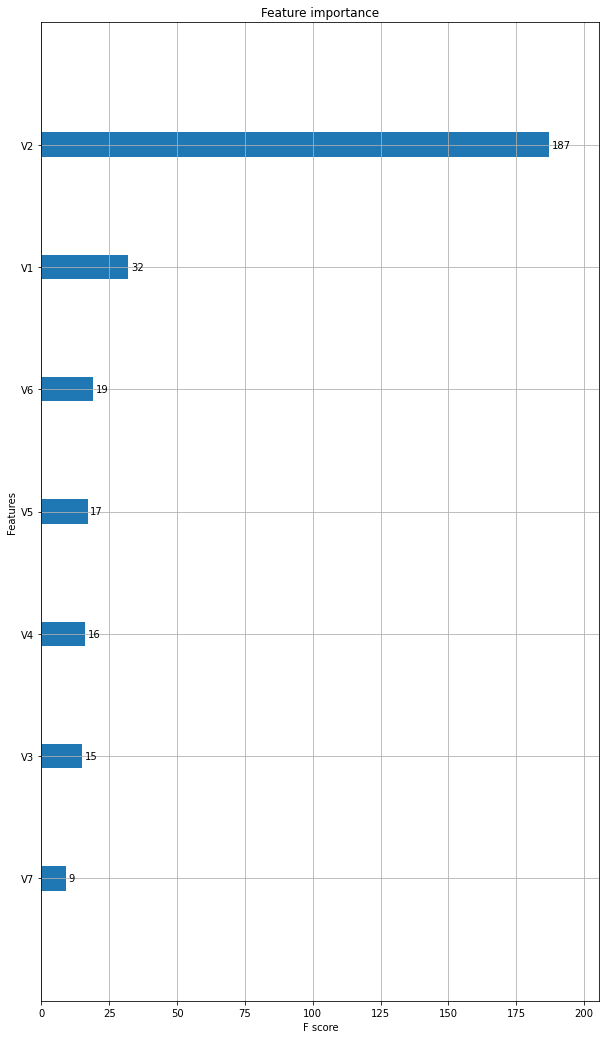

In [43]:
# check which features are important

from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 18));
xgb.plot_importance(model, ax=ax);

In [44]:
# confusion matrix
valid_pred = model.predict(X_valid)
cm = sk.metrics.confusion_matrix
cm(Y_valid, valid_pred)

array([[11979,  4787],
       [   89,    52]])

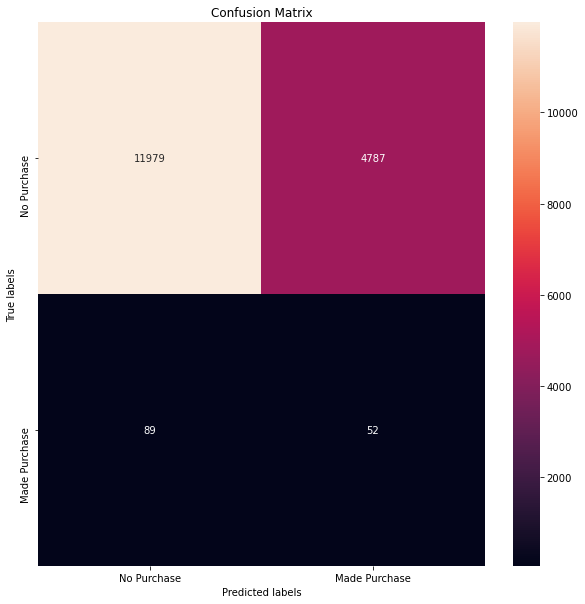

In [45]:
# confusion marix for the validation set
valid_pred = model.predict(X_valid)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [46]:
# calculate the accuracy
accuracy_score(Y_valid, valid_pred)

0.7115987460815048

In [47]:
#transform 0/1 array in prediction to Yes/No array
my_map = {0: "No", 1: "Yes"}
promotion = np.vectorize(my_map.get)(valid_pred)

In [48]:
promotion

array(['No', 'No', 'No', ..., 'Yes', 'Yes', 'Yes'], dtype='<U3')

In [81]:
#This dataframe is useful as a unit test to compare star bucks values with the ones we obtained in this model
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    preds = model.predict(test)

    promotion = []
    for pred in preds:
        if pred == 1:
            promotion.append('Yes')
        else:
            promotion.append('No')
    promotion = np.array(promotion)
    return promotion

In [53]:
# Use the test data on our model
test_data = pd.read_csv('./Test.csv')
df = test_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]

In [54]:
#pass the test dataframe to our model in the promotion strategy dataframe
promotion_strategy(df)

array(['No', 'No', 'Yes', ..., 'No', 'No', 'No'], dtype='<U3')

In [55]:
# Test results against those obtained by star bucks model
test_results(promotion_strategy)

Our irr with this strategy is 0.0175.

Our nir with this strategy is 142.30.
Starbucks came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.017548872164419627, 142.30000000000007)

In [70]:
test_ = pd.read_csv('./Test.csv')
df1 = test_[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
predictions = model.predict(df1)

In [82]:
promotion = []
    
for pred in predictions:
    if pred == 1:
        promotion.append('Yes')
    else:
        promotion.append('No')
promotion = np.array(promotion)

In [83]:
test_['Promotion_Strategy'] = promotion.tolist()

In [84]:
test_

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,Promotion_Strategy
0,2,No,0,1,41.376390,1.172517,1,1,2,2,No
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2,No
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2,Yes
3,10,No,0,2,28.529691,-1.078506,2,3,2,2,No
4,12,No,0,2,32.378538,0.479895,2,2,1,2,No
...,...,...,...,...,...,...,...,...,...,...,...
41645,126166,No,0,1,33.073275,-0.126150,2,2,2,2,Yes
41646,126174,Yes,0,0,32.065720,0.999361,2,3,2,1,Yes
41647,126176,Yes,1,3,27.691221,1.172517,2,2,1,2,No
41648,126177,Yes,0,2,32.306427,0.566472,1,2,4,1,No


In [85]:
test_.shape

(41650, 11)

In [87]:
# Accoding to our model, which are the best customers to target that maximizes the Incremental
#Response Rate and Net Incremental Revenue? 
test_[(test_['Promotion']=='Yes') & (test_['purchase']==1) & (test_['Promotion_Strategy']=='Yes')]

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,Promotion_Strategy
457,1411,Yes,1,0,19.164378,-0.299306,2,1,3,2,Yes
922,2816,Yes,1,0,27.993200,-0.732194,2,1,2,2,Yes
1002,3121,Yes,1,1,27.647377,-0.818772,2,1,2,2,Yes
1015,3153,Yes,1,2,25.188348,1.518828,2,1,1,2,Yes
1131,3496,Yes,1,1,32.844176,-0.212728,2,3,4,1,Yes
...,...,...,...,...,...,...,...,...,...,...,...
40044,121386,Yes,1,1,30.353005,-0.991928,2,3,1,2,Yes
40642,123166,Yes,1,1,27.259451,-0.732194,2,3,1,2,Yes
40890,123945,Yes,1,1,27.404750,-0.385883,1,3,1,2,Yes
41311,125171,Yes,1,1,26.863457,-1.251661,2,3,2,2,Yes


In [92]:
best_customers=test_[(test_['Promotion']=='Yes') & (test_['purchase']==1) & (test_['Promotion_Strategy']=='Yes')]

In [93]:
best_customers=best_customers.drop(['Promotion','purchase','V1','V2','V3','V4','V5','V6','V7','Promotion_Strategy'], axis=1)

In [95]:
best_customers.to_csv('Best_Customers_Target.csv')